# Matched Distribution and RFKO Tracking
(using Xtrack instead of PyBT)

- Start at resonance
- Add a quadrupole to move away from resonance
- Match a distribution
- Track and collapse quad over a few hundred turns
- You should see the ellipse transform into a triangular shape
- Then start RFKO

``dQ = Beta(at quad)*integrated_strength [m]*[m^-1]``


REFERNCE SIMPLE CASE - constantly on, simple noise
- [ ] No momentum spread
- [ ] Simpler functions
- [ ] Use RMS voltage = gaussian distribution, similar effect
- [ ] Look at sextupoles
- [ ] More particles?

- remove bumps

- [ ] Put septum in to remove particles - will remove "weirdness"

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Directory: ../new_septa_test/rfko_quadcollapse_I8ms_Q0.33_S-68.8_T3000

  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.04.19 10:51:27      +
  ++++++++++++++++++++++++++++++++++++++++++++
/**********************************************************************************

*

* Elements description and sequence file for each PS main unit (MU).

*

* 07/10/2020 - Alexander Huschauer

************************************************************************************/



/************************************************************************************

*

*         DEFINITION OF FOCUSING AND DEFOCUSING HALF-UNITS OF THE MU               

*

*************************************************************************************/



/************************************************************************************

*    

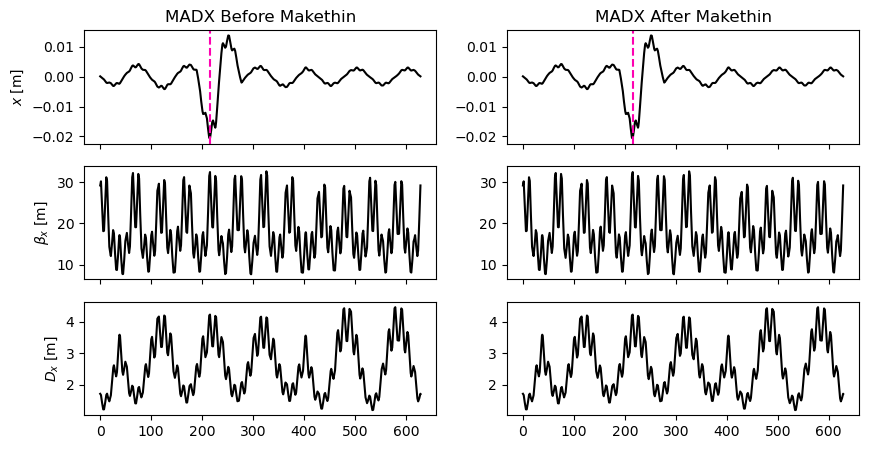

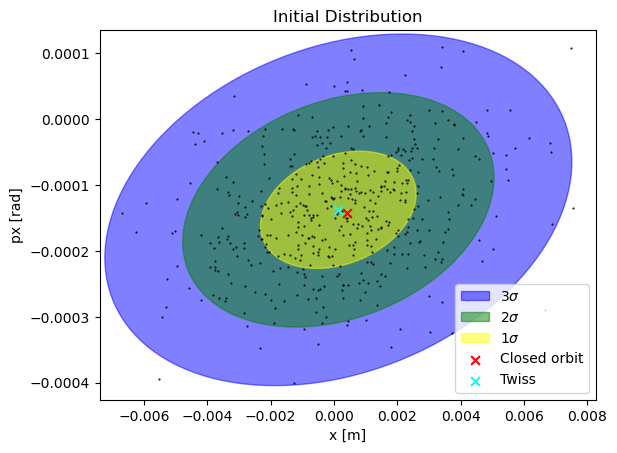

In [1]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import pybt

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np

from cpymad.madx import Madx

import scipy as sp

from progressbar import progressbar

import os

import pandas as pd

##########################################
###              CONSTANTS             ###
##########################################

REL_GAMMA = 25.598474067                    # relativistic gamma
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))       # relativistic beta
exn = 1.5e-6                                # emittance horizontal       
eyn = 1.5e-6                                # emittance vertical
ex = exn/(REL_BETA*REL_GAMMA)               # normalised emittance horizontal       
ey = eyn/(REL_BETA*REL_GAMMA)               # normalised emittance vertical

p = 24                                      # beam momentum (GeV/c)
momentum = 24                               # beam momentum (GeV/c)
Brho = 24*3.3356                            # magnetic rigidity (Tm)

PS_radius = 70.079                          # radius of the PS (m)
DPP_FACTOR = 1e-3                           # momentum deviation factor

N_PART = int( 500 )                         # number of particles

## QUAD COLLAPSE

TUNE_TARGET = 0.330                         # target tune
CHROMATICITY_TARGET = -3.165                  # target chromaticity
N_TURN = int( 500 )                         # number of turns for quad collapse

DETUNE_QUAD_KNL1 = -0.04                    # detune quad strength (kick)

## RFKO

CHIRP_START = .3                            # start freq of chirp (tune)
CHIRP_STOP = .35                            # stop freq of chirp (tune)
EXCITER_SAMPLING_FREQ = 1e6                 # sampling freq of exciter (Hz)

CHIRP_INTERVAL = 8 / 1000                   # interval between chirps (s)    
N_TURN_CHIRP = int( 1000 ) * 3                  # number of turns for chirp

SEPTA_X_MM = -68.8                            # septum x position (mm)
SEPTA_X_LIMIT_MM = -106.1 


GAIN = 0.15

DIR = f"../new_septa_test/rfko_quadcollapse_I{int(CHIRP_INTERVAL*1000)}ms_Q{round(TUNE_TARGET, 5)}_S{SEPTA_X_MM}_T{N_TURN_CHIRP}"


##########################################
###              MAKE DIR              ###
##########################################

os.makedirs(DIR, exist_ok=True)
print(f"Directory: {DIR}")
mad = Madx(stdout=True)

##########################################
###             CALL PS MADX           ###
##########################################

PS_REPO = "../../../../../models/acc-models-ps/"
mad.call(PS_REPO+"ps_mu.seq")
mad.call(PS_REPO+"ps_ss.seq")
mad.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")
# turn off 23 for ions
mad.input("kPEBSW23 := 0;")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26,K1,K2,K3;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')

def tune_match(Qx,Qxp,Qxpp,Qy,Qyp,Qypp,p,ex,ey):
    
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    # Call latice files
    madx.call(PS_REPO+"ps_mu.seq")
    madx.call(PS_REPO+"ps_ss.seq")
    madx.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

    madx.command.beam(particle='PROTON',
                      pc=p,
                      ex=ex,
                      ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.use(sequence = "PS")
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.input('savebeta, label=bumped23, place = PR.BPM23;')
    twiss_initial = madx.twiss().dframe()
    len_ps = twiss_initial.s[-1]

    ### Cycle sequence, changing starting point and adding markers at around the magnet 62
    madx.input('SEQEDIT, sequence=PS;')
    madx.input('FLATTEN;')
    madx.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
    madx.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
    madx.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence='ps')
    madx.select(flag='makethin', class_='rbend', slice_=4)
    madx.select(flag='makethin', class_='quadrupole', slice_=4)
    madx.select(flag='makethin', class_='sbend', slice_=4)
    madx.select(flag='makethin', class_='sextupole', slice_=2)
    madx.makethin(sequence='ps')
    madx.use(sequence='ps')

    twiss_cycled = madx.twiss().dframe()
    
    madx.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
      ptc_create_universe;
      ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
      IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
      }
      ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
      }
      ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    madx.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    madx.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")
    madx.input("Qxp2 := "+str(Qxpp)+"; !Horizontal Non-Linear Chromaticity")

    madx.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    madx.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")
    madx.input("Qyp2 := "+str(Qypp)+"; !Vertical Non-Linear Chromaticity")

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k3prpfwf;
            vary, name = k3prpfwd;
            use_macro, name = ptc_twiss_macro(3,0,0);
            constraint, expr = table(nonlin,value,5)  = Qxp2;
            constraint, expr = table(nonlin,value,10) = Qyp2;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;

    '''
    )
    
    madx.use(sequence="PS")
    twiss_tune_matching = madx.twiss().dframe() # Needed to refresh the tune values
    madx.input('qx = table(SUMM, Q1);')
    madx.input('qy = table(SUMM, Q2);')
    madx.input('qxp = table(SUMM, DQ1);')
    madx.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": madx.globals["qx"], "Qy": madx.globals["qy"], "Qxp": madx.globals["qxp"], "Qyp": madx.globals["qyp"]}
    pfw_dict = {"k1prpfwf": madx.globals["k1prpfwf"], "k1prpfwd": madx.globals["k1prpfwd"], "k2prpfwf": madx.globals["k2prpfwf"], "k2prpfwd": madx.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")

    madx.quit()
    
    return pfw_dict, tune_info_dict

# GET PFWS FOR TUNE
# Chromaticity of -0.5 is RELATIVE so multiply out by tune target
pfw_dict_on_resonance, tune_info_on_resonance = tune_match(Qx=TUNE_TARGET,Qxp=CHROMATICITY_TARGET,Qy=0.3,Qyp=-0.242, p=p, ex=ex, ey=ey, Qxpp=-100, Qypp=100) # Chroma from measurements on 12.11.21 

# SET PFWS
mad.input("k1prpfwf = "+str(pfw_dict_on_resonance["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(pfw_dict_on_resonance["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(pfw_dict_on_resonance["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(pfw_dict_on_resonance["k2prpfwd"])+";")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')

twiss_initial = mad.twiss().dframe()
len_ps = twiss_initial.s[-1]

# FLATTEN
mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
mad.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
mad.command.install(element = 'marker_seh23', class_='MARKER', at=-0.4, from_='PE.SEH23')

# CYCLE
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')
mad.use(sequence = "PS")

initial_conditions = (-0.07, (-0.00135 + -0.0015)/2)
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
twiss_cycled_beta = mad.twiss(x=initial_conditions[0], px=initial_conditions[1], beta0="bumped23").dframe()
twiss_cycled = mad.twiss().dframe()

twiss_before_makethin = mad.twiss().dframe()

# MAKETHIN
QUAD_SLICE = 4
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='quadrupole', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='sbend', slice_=QUAD_SLICE)
mad.select(flag='makethin', class_='hkicker', slice_=QUAD_SLICE, thick=False)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')

twiss_after_makethin = mad.twiss().dframe()

# CONVERT TO XTRACK
mad.use(sequence="PS")
line = xt.Line.from_madx_sequence(
    mad.sequence(),
    )
fig, ax = plt.subplots(3, 2, figsize = (10, 5), sharex=True)

madx_smh57_location = twiss_after_makethin.s[np.where(twiss_after_makethin.name == 'pe.smh57:1')[0][0]]

ax[0, 0].plot(twiss_before_makethin.s, twiss_before_makethin.x, 'k', label='MADX')
ax[0, 1].plot(twiss_after_makethin.s, twiss_after_makethin.x, 'k', label='MADX')

ax[1, 0].plot(twiss_before_makethin.s, twiss_before_makethin.betx, 'k', label='MADX')
ax[1, 1].plot(twiss_after_makethin.s, twiss_after_makethin.betx, 'k', label='MADX')

ax[2, 0].plot(twiss_before_makethin.s, twiss_before_makethin.dx, 'k', label='MADX')
ax[2, 1].plot(twiss_after_makethin.s, twiss_after_makethin.dx, 'k', label='MADX')


ax[0, 0].axvline(madx_smh57_location, color='xkcd:bright pink', linestyle='--')
ax[0, 1].axvline(madx_smh57_location, color='xkcd:bright pink', linestyle='--')

ax[0, 0].set_title("MADX Before Makethin")
ax[0, 1].set_title("MADX After Makethin")

ax[0, 0].set_ylabel(r"$x$ [m]")
ax[1, 0].set_ylabel(r"$\beta_x$ [m]")
ax[2, 0].set_ylabel(r"$D_x$ [m]")

fig.savefig(f"{DIR}/twiss_comparison.png")

KPRQSE_START = 0.1224767158
KPRQSE_END = 0.1379634524
qse_29_ids = [i for i, n in enumerate(line.element_names) if "qse29" in n]
qse_87_ids = [i for i, n in enumerate(line.element_names) if "qse27" in n]

##########################################
###             SET UP LINE            ###
##########################################

ctx = xo.ContextCpu()
line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)
tracker = line.build_tracker()
co_guess = line.build_particles(
    x = initial_conditions[0],
    px = initial_conditions[1],
)
tw = tracker.twiss(method='4d')

print(f"Dispersion at seh23: {tw['dx'][[i for i, n in enumerate(tw['name']) if 'seh23' in n][0]]}")
print(f"Dispersion at smh57: {tw['dx'][[i for i, n in enumerate(tw['name']) if 'smh57' in n][0]]}")
FREV = 1/tw['T_rev']
x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(N_PART)

##########################################
###            BUILD PARTICLES         ###
##########################################
# TODO: Explain why approximations, or show its the same without approximations

particles = line.build_particles(method='4d',
                    x_norm=x_in_sigmas, # sigmas
                    px_norm=px_in_sigmas, # sigmas
                    nemitt_x=exn, nemitt_y=eyn)

##########################################
###            PLOT INIT DIST          ###
##########################################

cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

co = tracker.find_closed_orbit()
tw = tracker.twiss(method='4d')
parms =  pybt.tools.particles.get_parms(particles.x, particles.px)

fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
from matplotlib.patches import Ellipse, Rectangle
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='x', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Initial Distribution")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')

fig.savefig(f"{DIR}/initial_distribution.png")


##########################################
###       ADD MONITORS AND SEPTA       ###
##########################################

line.unfreeze()
smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN+N_TURN_CHIRP
)
smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN+N_TURN_CHIRP
)
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)

septum = xt.LimitRect(
    min_x = SEPTA_X_MM*0.001, # in meters
    #max_x = SEPTA_X_LIMIT_MM*0.001, # in meters
)
line.insert_element(
    element = septum,
    name = "SEPTUM",
    index = 'pe.smh57'
)

Before: f = -0.3425892323, d = 0.3331200184

In [2]:
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,K2L,K3L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input("TWISS, FILE='twtw.tfs'")

enter Twiss module
  
iteration:   1 error:   3.778269E-03 deltap:   0.000000E+00
orbit:   1.775727E-04 -1.353597E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   1.327311E-05 deltap:   0.000000E+00
orbit:   1.371955E-04 -1.375480E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   6.214928E-10 deltap:   0.000000E+00
orbit:   1.371929E-04 -1.375481E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0        0.025768359        6.229549181 

                q1                dq1            betxmax              dxmax 
       6.326595311       -3.365363504        32.80098047        4.483566617 

             dxrms             xcomax             xcorms                 q2 
       2.739902394       0.0206440612     0.004660420713         6.30564114 

               dq2            

True

In [3]:
twhead, twdic = pybt.tools.parsers.read_twiss_file('twtw.tfs')

In [4]:
list(twdic[twdic['k3l'] != 0].index)

['pr.mp23.f',
 'pr.mp23.d',
 'pr.mp24.d',
 'pr.mp24.f',
 'pr.mp25.f',
 'pr.mp25.d',
 'pr.mp26.d',
 'pr.mp26.f',
 'pr.mp27.f',
 'pr.mp27.d',
 'pr.mp28.d',
 'pr.mp28.f',
 'pr.mp29.f',
 'pr.mp29.d',
 'pr.mp30.d',
 'pr.mp30.f',
 'pr.mp31.f',
 'pr.mp31.d',
 'pr.mp32.d',
 'pr.mp32.f',
 'pr.mp33.f',
 'pr.mp33.d',
 'pr.mp34.d',
 'pr.mp34.f',
 'pr.mp35.f',
 'pr.mp35.d',
 'pr.mp36.d',
 'pr.mp36.f',
 'pr.mp37.f',
 'pr.mp37.d',
 'pr.mp38.d',
 'pr.mp38.f',
 'pr.mp39.f',
 'pr.mp39.d',
 'pr.mp40.d',
 'pr.mp40.f',
 'pr.mp41.f',
 'pr.mp41.d',
 'pr.mp42.d',
 'pr.mp42.f',
 'pr.mp43.f',
 'pr.mp43.d',
 'pr.mp44.d',
 'pr.mp44.f',
 'pr.mp45.f',
 'pr.mp45.d',
 'pr.mp46.d',
 'pr.mp46.f',
 'pr.mp47.f',
 'pr.mp47.d',
 'pr.mp48.d',
 'pr.mp48.f',
 'pr.mp49.f',
 'pr.mp49.d',
 'pr.mp50.d',
 'pr.mp50.f',
 'pr.mp51.f',
 'pr.mp51.d',
 'pr.mp52.d',
 'pr.mp52.f',
 'pr.mp53.f',
 'pr.mp53.d',
 'pr.mp54.d',
 'pr.mp54.f',
 'pr.mp55.f',
 'pr.mp55.d',
 'pr.mp56.d',
 'pr.mp56.f',
 'pr.mp57.f',
 'pr.mp57.d',
 'pr.mp58.d',
 'pr.m

generating ./27cbdcc8395f42469abed27129c7ff6a.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'
enter Twiss module
  
iteration:   1 error:   3.778269E-03 deltap:   0.000000E+00
orbit:   1.775727E-04 -1.353597E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   1.327311E-05 deltap:   0.000000E+00
orbit:   1.371955E-04 -1.375480E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   6.214928E-10 deltap:   0.000000E+00
orbit:   1.371929E-04 -1.375481E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0        0.025768359        6.229549181 

                q1                dq1            betxmax              dxmax 
       6.326595311       -3.365363504        32.80098047        4.483566617 

             dxrms             xcomax             xcorms  

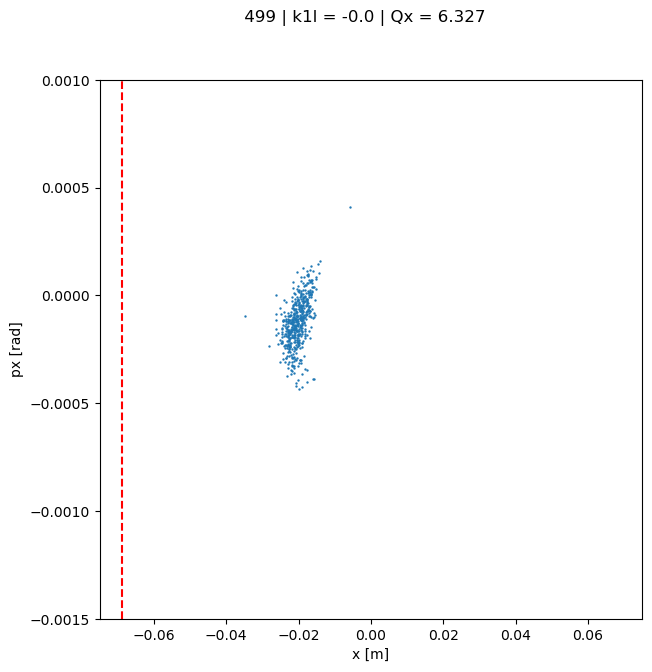

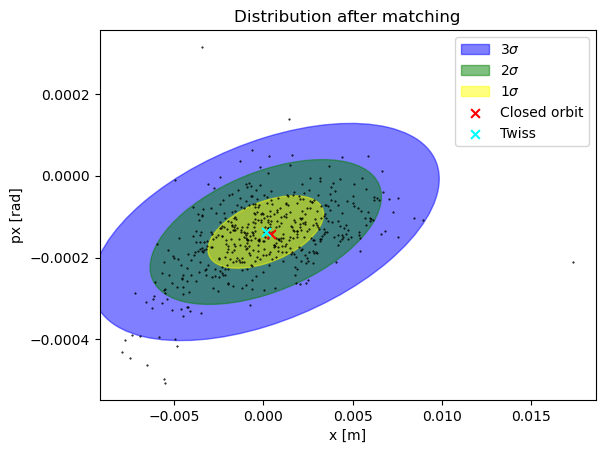

In [5]:

detuning_quad = xt.SimpleThinQuadrupole(
    knl = [0, DETUNE_QUAD_KNL1]
)
line.insert_element(
    element = detuning_quad,
    index = 0,
    name = "DETUNING_QUAD"
)
tracker = line.build_tracker()

# Perform MAD twiss
mad_twiss = mad.twiss()
mad_twiss_summ = mad_twiss.summary

# Track
tunes = []
strengths = []
print(f"Tracking for particle {N_TURN} for detuning, {N_TURN_CHIRP} for rfko")

##########################################
###         DETUNE QUAD COLLAPSE       ###
##########################################


delta = line['DETUNING_QUAD'].knl[1]/N_TURN
for turn in range(N_TURN):
    # Detuning
    cur_strength = line['DETUNING_QUAD'].knl[1]
    line['DETUNING_QUAD'].knl[1] = cur_strength - delta
    tracker.track(particles)
    tune = tracker.twiss(method='4d')['qx']
    tunes.append(tune)
    strengths.append(line['DETUNING_QUAD'].knl[1])
tune_before = tw['qx']
print(f"Tune before detune: {tune_before}")
tw = tracker.twiss(method='4d')
tune_after = tw['qx']
print(f"Tune after detune: {tune_after}")

##########################################
###            PLOT DETUNE GIF         ###
##########################################

from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlabel("x [m]")
    ax.set_ylabel("px [rad]")
    ax.set_xlim(-0.075, 0.075)
    ax.set_ylim(-0.0015, 0.001)
    fig.suptitle(f"{i:>4}")
    fig.suptitle(f"{i:>4} | k1l = {round(strengths[i], 4):>4} | Qx = {round(tunes[i], 3):>4}")
    ax.axvline(SEPTA_X_MM*0.001, color='red', linestyle='--', label='Septa')
    try:
        ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN)
ani.save(f"{DIR}/quad_collapse.gif", writer=PillowWriter(fps=30))

##########################################
###            PLOT FINAL DIST         ###
##########################################

cov = np.cov([particles.x, particles.px])
cov_px = np.cov(particles.px)

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

co = tracker.find_closed_orbit()
tw = tracker.twiss(method='4d')
parms = pybt.tools.particles.get_parms(particles.x, particles.px)

fig, ax = plt.subplots()
ax.plot(particles.x, particles.px, 'k.', markersize=1, zorder=3)
e3 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w3, height=h3, angle=r3, color='blue', alpha=.5, label='3$\sigma$')
e2 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w2, height=h2, angle=r2, color='green', alpha=.5, label='2$\sigma$')
e1 = Ellipse(xy=(tw.x[0], tw.px[0]), width=w1, height=h1, angle=r1, color='yellow', alpha=.5, label='1$\sigma$')

# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e3)
ax.add_artist(e2)
ax.add_artist(e1)

ax.scatter(co.x, co.px, color='red', marker='x', s=40, label='Closed orbit', zorder=4)
ax.scatter(tw.x[0], tw.px[0], color="xkcd:cyan", marker='x', s=40, label="Twiss", zorder=6)

ax.plot()
ax.legend()

ax.set_title("Distribution after matching")
ax.set_xlabel('x [m]')
ax.set_ylabel('px [rad]')

fig.savefig(f"{DIR}/final_distribution.png")
particles_df = particles.to_pandas()
particles_df.to_hdf('test_part.hdf', key='particles_df', mode='w')


In [6]:

###############################################
#  _______     ________  ___  ____    ___     #
# |_   __ \   |_   __  ||_  ||_  _| .'   `.   #
#   | |__) |    | |_ \_|  | |_/ /  /  .-.  \  #
#   |  __ /     |  _|     |  __'.  | |   | |  #
#  _| |  \ \_  _| |_     _| |  \ \_\  `-'  /  #
# |____| |___||_____|   |____||____|`.___.'   #
#                                             #
###############################################

from signal_gen import generate_chirp

chirp_time, chirp_signal = generate_chirp(
    sampling_freq = EXCITER_SAMPLING_FREQ,
    chirp_start_freq = CHIRP_START*FREV,
    chirp_stop_freq = CHIRP_STOP*FREV,
    chirp_rep_time = CHIRP_INTERVAL,
    turn_freq=FREV
)
from scipy import constants
def kick_angle(gain=.1):
    c = constants.c # m/s, speed of light
    E0 = 0.93827e9 # eV, proton rest energy
    mu0 = 4*np.pi*(10**-7) # H/m, vacuum permeability

    T = 2e9 # eV, proton KE
    P = 5e3 # W, TFB peak power / electrode
    Z = 100 # Ohm, TFB impedance / electrode

    L = 935e-3 # m, TFB length
    r = 70e-3 # m, TFB separation

    E = T + E0 # Total Energy
    gamma = E / E0 # Normalized energy (lorentz)
    beta = np.sqrt(1-gamma**-2) # normalised velocity (lorentz)
    cp = np.sqrt(E**2 - E0**2) # eV, particle momentum

    # Electric Field
    Vp = np.sqrt(P * Z * 2) # peak voltage
    V = Vp * gain
    Efield = V / r # adjusted for gain

    # Magnetic Field
    I = np.sqrt((V**2/Z)/Z*2) # current
    Hfield = (2*I) / (2*np.pi*r) # adjusted for gain
    Bfield = Hfield * mu0

    # Angle
    theta_M = c/1e9*Bfield*L / (cp/10**9)
    theta_E = Efield/1e9*L / (cp/10**9 * beta)
    theta = theta_E + theta_M
    return theta

rfko_kick = kick_angle(0.1)
                                         
mad.use(sequence="PS")
line.unfreeze()
rfko_exciter = xt.Exciter(
    _context = ctx,
    samples = chirp_signal,
    sampling_frequency = EXCITER_SAMPLING_FREQ,
    frev = FREV,
    start_turn = 0,
    knl = [rfko_kick],
    duration = N_TURN_CHIRP/FREV
)
line.insert_element(
    element = rfko_exciter,
    name = f'EXCITER',
    index = 'pr.kfb97'
)


In [7]:
particles = xp.Particles.from_pandas(pd.read_hdf('test_part.hdf'))

In [8]:
rfko_line = line.build_tracker()

generating ./24a10317cb204abab4b55d132be3772a.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation/jobs'


In [10]:
RAD_TO_MRAD = 1000
M_TO_MM = 1000

import pickle as pkl

xs = []
ss = []
tw = rfko_line.twiss(method='4d')

# for t in range(N_TURN_CHIRP):
#     rfko_line.track(particles, num_turns = 3, turn_by_turn_monitor = 'ONE_TURN_EBE')
#     if any([x[1845]*M_TO_MM == 0 for x in line.record_last_track.x]):
#         print("zeroes")
#     if any([x[1845]*M_TO_MM < SEPTA_X_MM for x in line.record_last_track.x]):
#         #ax.plot(line.record_last_track.s, line.record_last_track.x*M_TO_MM, 'k-', lw=1)
#         with open(f"optics_tracking/{t}.pkl", "wb") as f:
#             pkl.dump(line.record_last_track.x, f)
#         print(">> into septa")

rfko_line.track(
    particles,
    num_turns = N_TURN_CHIRP
)


loss_list = list(zip(particles.at_turn, zip(particles.x, particles.px)))


In [11]:
twsum = tw.get_summary()

In [12]:
initial_particles = xp.Particles.from_pandas(pd.read_hdf('test_part.hdf'))

Text(0.5, 1.0, 'Phase Space population at SMH57')

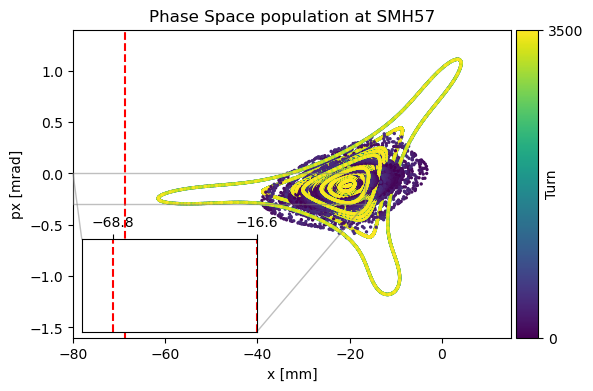

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
# import colors
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# get viridis colormap
cm = plt.get_cmap('viridis')
for i in range(N_PART):
    sctr = ax.scatter(M_TO_MM*smh57_monitor.x[i], RAD_TO_MRAD*smh57_monitor.px[i], cmap=cm, c=smh57_monitor.at_turn[i], s=2)
ax.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')

smh57loc = [i for i, n in enumerate(line.element_names) if "SMH57" in n][0]

e2 = Ellipse(
    xy=(tw.x[smh57loc]*M_TO_MM, tw.px[smh57loc]*RAD_TO_MRAD), 
    width=w2*M_TO_MM, height=h2*M_TO_MM, angle=r2, 
    fc='none', 
    label='2$\sigma$', 
    ec='red', 
    lw=2,
    ls='--',
    zorder=10,)

e3 = Ellipse(
    xy=(tw.x[smh57loc]*M_TO_MM, tw.px[smh57loc]*RAD_TO_MRAD), 
    width=w3*M_TO_MM, height=h3*M_TO_MM, angle=r3, 
    fc='none', 
    label='2$\sigma$', 
    ec='red', 
    lw=2,
    ls='--',
    zorder=10,)


# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

#ax.add_artist(e2)
#ax.add_artist(e3)


axins = ax.inset_axes([0.02, 0.02, 0.4, 0.3])
x1 = -80
x2 = -65
y1 = -0.3
y2 = 0
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.scatter(particles.x*M_TO_MM, particles.px*RAD_TO_MRAD, s=3, c='black')
axins.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')
axins.axvline(min(particles.x*M_TO_MM), color='red', linestyle='--')
axins.xaxis.tick_top()
axins.yaxis.tick_right()
axins.set_xticks([round(min(particles.x*M_TO_MM),1), round(SEPTA_X_MM, 1)])
axins.set_yticks([])

ax.scatter(0, 0, s=5, c='white')

ax.indicate_inset_zoom(axins)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sctr, cax=cax, orientation='vertical')
cax.set_ylabel("Turn")
cax.yaxis.set_label_coords(1.3, .5)

cax.set_yticks([cax.get_yticks()[0], cax.get_yticks()[-1]])
cax.set_yticklabels([0, N_TURN_CHIRP+N_TURN])
ax.set_xlim(-80, 15)
ax.set_ylim(-1.6, 1.4)
ax.set_xlabel("x [mm]")
ax.set_ylabel("px [mrad]")
ax.set_title("Phase Space population at SMH57")

In [14]:
with open(f"optics_tracking/s.pkl", "wb") as f:
    pkl.dump(line.record_last_track.s, f)

AttributeError: 'NoneType' object has no attribute 's'

In [ ]:
[(i, n) for i, n in enumerate(line.element_names) if "SMH57_MONITOR" in n]

In [ ]:
line.record_last_track.s[0][1845]

In [ ]:
dir(line.record_last_track)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 3))

for p in os.listdir("optics_tracking"):
    with open(f"optics_tracking/{p}", "rb") as f:
        x = pkl.load(f)
    print("next")
    ax.plot(line.record_last_track.s, x*M_TO_MM, 'k-', lw=1)

In [ ]:

##########################################
###           PLOT PHASE SPACE         ###
##########################################

fig, ax = plt.subplots()
# import colors
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# get viridis colormap
cm = plt.get_cmap('viridis')
for i in range(N_PART):
    sctr = ax.scatter(M_TO_MM*smh57_monitor.x[i], RAD_TO_MRAD*smh57_monitor.px[i], cmap=cm, c=smh57_monitor.at_turn[i], s=2)
ax.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')
ax.set_xlim(-80, 20)
ax.set_ylim(-1.7, 1.3)
ax.set_xlabel("x [mm]")
ax.set_ylabel("px [mrad]")
ax.set_title("RFKO Phase Space")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sctr, cax=cax, orientation='vertical')
cax.set_ylabel("Turn")
cax.set_yticks([cax.get_yticks()[0], cax.get_yticks()[-2]])
cax.set_yticklabels([0, N_TURN_CHIRP])

# add colorbar

fig.savefig(f"{DIR}/rfko_phase_space.png")
##########################################
###             COUNTS CALC            ###
##########################################

cts_dict = dict(zip(*np.unique(particles.at_turn, return_counts=True)))
turn_counts = []
turn_culm = []
for trn in range(N_TURN_CHIRP+N_TURN):
    try:
        turn_counts.append(cts_dict[trn])
        turn_culm.append(turn_culm[-1] + cts_dict[trn])
    except KeyError:
        turn_counts.append(0)
        try:
            turn_culm.append(turn_culm[-1])
        except IndexError:
            turn_culm.append(0)
##########################################
###            PLOT EXTRACTION         ###
##########################################

from collections import Counter
counter_turns, counter_counts = list(zip(*sorted(Counter(particles.at_turn).items())))
counter_turns = np.array(counter_turns)
counter_counts = np.array(counter_counts)
counter_culm = np.cumsum(counter_counts)

fig = plt.figure()
ax3 = fig.add_subplot(111, label='3')
ax2 = fig.add_subplot(111, label='2', frame_on=False)
ax = fig.add_subplot(111, label='1', frame_on=False)


chirp_duration = N_TURN_CHIRP/FREV
samples_for_chirp = chirp_duration*EXCITER_SAMPLING_FREQ
samples_to_extend = int(samples_for_chirp)
quad_collapse_duration = N_TURN/FREV
samples_for_quad_collapse = quad_collapse_duration*EXCITER_SAMPLING_FREQ
quad_collapse_to_extend = int(samples_for_quad_collapse)
ax3.plot(np.linspace(0, chirp_duration+quad_collapse_duration, samples_to_extend+quad_collapse_to_extend), np.pad(np.pad(chirp_signal, pad_width=(0, samples_to_extend-len(chirp_signal)), mode='wrap'), pad_width=(quad_collapse_to_extend, 0), mode='constant', constant_values=0), label='Chirp', color='blue', alpha=.5)
ax3.set_xlim(0, chirp_duration+quad_collapse_duration)
ax3.set_ylim(0, 1)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)


ax.plot(range(N_TURN+N_TURN_CHIRP), turn_counts, 'k-', zorder=1)
ax.set_ylim(0, max(turn_counts)*1.1)
ax.set_xlim(0, N_TURN+N_TURN_CHIRP)


ax2.plot(range(N_TURN+N_TURN_CHIRP), turn_culm, 'r-', zorder=1)
ax2.yaxis.tick_right()
ax2.set_xlim(0, N_TURN+N_TURN_CHIRP)
ax2.set_ylim(0, N_PART)

ax.set_xlabel("Turn")
ax.set_ylabel("Particles lost per turn", color='k')
ax2.set_ylabel("Cumulative particles lost", color='k')

# set title
ax.set_title("Particle Losses")
fig.savefig(f"{DIR}/extraction.png")

##########################################
###              PLOT GIF              ###
##########################################


# from matplotlib import animation

# fig = plt.figure(figsize=(8, 6))

# sf, sf2 = fig.subfigures(2, 1, height_ratios=[1, .3])
# plt.subplots_adjust(bottom=0.25)

# ax = sf.add_subplot(111, label='1')
# ax2 = sf2.add_subplot(111, label='2', frame_on=True, axisbelow=True)
# ax22 = sf2.add_subplot(111, label='22', frame_on=False, axisbelow=True, sharex=ax2)
# ax3 = sf2.add_subplot(111, label='3', frame_on=False, axisbelow=True)

# ax.set_ylim(-1.7, 1.3)
# ax.set_xlim(-80, 20)
# ax.set_xlabel("x [m]")
# ax.set_ylabel("px [rad]")

# ax.set_box_aspect(1)

# # Phase Space
# line, = ax.plot([], [], 'k.', markersize=2)
# loss, = ax.plot([], [], 'r.', markersize=6, zorder=10, alpha=1)
# lossf1, = ax.plot([], [], 'r.', markersize=5, zorder=9, alpha=.9)
# lossf2, = ax.plot([], [], 'r.', markersize=4, zorder=8, alpha=.8)
# loss_remain, = ax.plot([], [], marker='.', color="xkcd:salmon" , markersize=5, zorder=5, alpha=.5, linestyle='None')

# # Extraction
# instant, = ax2.plot([], [], 'k-')
# ax2.set_ylim(0, max(turn_counts)*1.1)
# ax2.set_xlim(0, N_TURN_CHIRP+N_TURN)

# culm, = ax22.plot([], [], 'r-')
# ax22.yaxis.tick_right()
# ax22.yaxis.label_position = "right"
# ax22.set_ylim(0, N_PART)
# ax22.set_xlim(0, N_TURN_CHIRP+N_TURN)

# ax2.set_xlabel("Turns", labelpad=10)
# ax2.xaxis.set_label_coords(-0.04, -0.1)
# ax222 = ax2.secondary_xaxis('top', functions=(lambda x: x/FREV, lambda x: x/FREV))
# ax222.set_ylabel("Time [s]", rotation=0, labelpad=10)
# ax2.set_ylabel("[cts. / turn]")
# ax22.set_ylabel("total cts.")

# # Chirp signal
# chirp_duration = N_TURN_CHIRP/FREV
# samples_for_chirp = chirp_duration*EXCITER_SAMPLING_FREQ
# samples_to_extend = int(samples_for_chirp)
# quad_collapse_duration = N_TURN/FREV
# samples_for_quad_collapse = quad_collapse_duration*EXCITER_SAMPLING_FREQ
# quad_collapse_to_extend = int(samples_for_quad_collapse)

# chirp, = ax3.plot([], [], 'b', zorder=1, alpha=.5)
# ax3.set_xlim(0, chirp_duration+quad_collapse_duration)
# ax3.set_ylim(0, 1)
# ax3.get_xaxis().set_visible(False)
# ax3.get_yaxis().set_visible(False)

# sept = ax.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')
# def init():
#     line.set_data([], [])

#     loss.set_data([], [])
#     lossf1.set_data([], [])
#     lossf2.set_data([], [])
#     loss_remain.set_data([], [])

#     instant.set_data([], [])
#     culm.set_data([], [])
#     chirp.set_data([], [])
#     return line, instant, culm, loss, chirp
# def animate(i):

#     turn = N_TURN+(i*3)

#     x = M_TO_MM*smh57_monitor.x.T[turn:turn+2]
#     y = RAD_TO_MRAD*smh57_monitor.px.T[turn:turn+2]
#     line.set_data(x, y)

#     try: loss_x, loss_y = list(zip(*np.array(loss_list)[np.where(np.logical_and(turn <= np.array(loss_list)[:,0], np.array(loss_list)[:,0] <= turn+2))[0]][:,1]))
#     except ValueError: loss_x, loss_y = [], []

#     try: lossf1_x, lossf1_y = list(zip(*np.array(loss_list)[np.where(np.logical_and(turn-3 <= np.array(loss_list)[:,0], np.array(loss_list)[:,0] <= turn-1))[0]][:,1]))
#     except ValueError: lossf1_x, lossf1_y = [], []

#     try: lossf2_x, lossf2_y = list(zip(*np.array(loss_list)[np.where(np.logical_and(turn-6 <= np.array(loss_list)[:,0], np.array(loss_list)[:,0] <= turn-4))[0]][:,1]))
#     except ValueError: lossf2_x, lossf2_y = [], []

#     try: loss_remain_x, loss_remain_y = list(zip(*np.array(loss_list)[np.where(np.array(loss_list)[:,0] <= turn-7)[0]][:,1]))
#     except ValueError: loss_remain_x, loss_remain_y = [], []

#     loss.set_data(np.array(loss_x)*M_TO_MM, np.array(loss_y)*RAD_TO_MRAD)
#     lossf1.set_data(np.array(lossf1_x)*M_TO_MM, np.array(lossf1_y)*RAD_TO_MRAD)
#     lossf2.set_data(np.array(lossf2_x)*M_TO_MM, np.array(lossf2_y)*RAD_TO_MRAD)
#     loss_remain.set_data(np.array(loss_remain_x)*M_TO_MM, np.array(loss_remain_y)*RAD_TO_MRAD)

#     #sf.suptitle(f"Turn {turn}")

#     instant_x = range(turn)
#     instant_y = turn_counts[:turn]
#     instant.set_data(instant_x, instant_y)

#     culm_x = range(turn)
#     culm_y = turn_culm[:turn]
#     culm.set_data(culm_x, culm_y)

#     chirp_x = np.linspace(0, chirp_duration+quad_collapse_duration, samples_to_extend+quad_collapse_to_extend)
#     chirp_y = np.pad(np.pad(chirp_signal, pad_width=(0, samples_to_extend-len(chirp_signal)), mode='wrap'), pad_width=(quad_collapse_to_extend, 0), mode='constant', constant_values=0)
#     chirp.set_data(chirp_x, chirp_y)
    
#     return line, instant, culm, loss, chirp

# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=int(N_TURN_CHIRP/3), interval=1, blit=True)
# #                               frames=int(6), interval=1, blit=True)
# anim.save(f'{DIR}/rfko.gif', 
#           writer=animation.PillowWriter(fps=30),
#           )
##########################################
###              SAVE DATA             ###
##########################################

import pickle as pkl
# Particles
particles.to_pandas().to_parquet(f"{DIR}/particles.parquet")

with open(f"{DIR}/loss_locations.pkl", "wb") as f:
    pkl.dump(loss_list, f)
# with open(f"{DIR}/extraction.pkl", "wb") as f:
#     pkl.dump(np.array(list(zip(*sorted(Counter(particles.at_turn).items())))), f)
# Sequence
mad.save(sequence = 'ps', file = f"{DIR}/sequence.seq")
constant_dict = {
    "distribution":
        {
            "rel_gamma": REL_GAMMA,
            "rel_beta": REL_BETA,
            "exn": exn,
            "eyn": eyn,
            "ex": ex,
            "ey": ey,
            "p": p,
            "momentum": momentum,
            "Brho": Brho,
            "DPP_FACTOR": DPP_FACTOR,
            "N_PART": N_PART,
        },
    "quad_collapse":
        {
            "TUNE_TARGET": TUNE_TARGET,
            "CHROMATICITY_TARGET": CHROMATICITY_TARGET,
            "N_TURN": N_TURN,
            "DETUNE_QUAD_KNL1": DETUNE_QUAD_KNL1,
        },
    "rfko":
        {
            "EXCITER_SAMPLING_FREQ": EXCITER_SAMPLING_FREQ,
            "FREV": FREV,
            "CHIRP_START": CHIRP_START,
            "CHIRP_STOP": CHIRP_STOP,
            "CHIRP_INTERVAL": CHIRP_INTERVAL,
            "N_TURN_CHIRP": N_TURN_CHIRP,
            "SEPTA_X_MM": SEPTA_X_MM,
        },
}
# save to file
with open(f"{DIR}/constants.json", "w") as f:
    json.dump(constant_dict, f, indent=4)
import pickle as pkl
with open(f"{DIR}/turn_counts_zip.pkl", "wb") as f:
    pkl.dump(list(zip(range(N_TURN+N_TURN_CHIRP), turn_counts)), f)
with open(f"{DIR}/turn_counts.pkl", "wb") as f:
    pkl.dump(turn_counts, f)

with open(f"{DIR}/turn_culm_zip.pkl", "wb") as f:
    pkl.dump(list(zip(range(N_TURN+N_TURN_CHIRP), turn_culm)), f)
with open(f"{DIR}/turn_culm.pkl", "wb") as f:
    pkl.dump(turn_culm, f)

    

In [ ]:
tw_test = rfko_line.twiss(method='4d')

In [ ]:
tw_test['qx']

In [ ]:
with open(f"{DIR}/monitor.pkl", "wb") as f:
    pkl.dump(smh57_monitor.to_dict(), f)

In [ ]:
cov = np.cov([smh57_monitor.x.T[0], smh57_monitor.px.T[0]])
cov_px = np.cov(smh57_monitor.px.T[0])

w3, h3, r3 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=3)
w2, h2, r2 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=2)
w1, h1, r1 = pybt.tools.particles.ellipse_frm_cov(cov, nsig=1)

line.unfreeze()
tr = line.build_tracker()
co = tr.find_closed_orbit()
tw = tr.twiss(method='4d')
parms =  pybt.tools.particles.get_parms(particles.x, particles.px)

In [ ]:
smh57loc = [i for i, n in enumerate(tw['name']) if "SMH57" in n][0]

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
# import colors
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# get viridis colormap
cm = plt.get_cmap('viridis')
for i in range(N_PART):
    sctr = ax.scatter(M_TO_MM*smh57_monitor.x[i], RAD_TO_MRAD*smh57_monitor.px[i], cmap=cm, c=smh57_monitor.at_turn[i], s=2)
ax.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')


e2 = Ellipse(
    xy=(tw.x[smh57loc]*M_TO_MM, tw.px[smh57loc]*RAD_TO_MRAD), 
    width=w2*M_TO_MM, height=h2*M_TO_MM, angle=r2, 
    fc='none', 
    label='2$\sigma$', 
    ec='red', 
    lw=2,
    ls='--',
    zorder=10,)

e3 = Ellipse(
    xy=(tw.x[smh57loc]*M_TO_MM, tw.px[smh57loc]*RAD_TO_MRAD), 
    width=w3*M_TO_MM, height=h3*M_TO_MM, angle=r3, 
    fc='none', 
    label='2$\sigma$', 
    ec='red', 
    lw=2,
    ls='--',
    zorder=10,)


# septa_region = Rectangle((septum.min_x, septum.min_y), septum.max_x-septum.min_x, septum.max_y-septum.min_y, color='red', alpha=.5, label='Septa')
# ax.add_artist(septa_region)

ax.add_artist(e2)
#ax.add_artist(e3)

axins = ax.inset_axes([0.02, 0.02, 0.4, 0.3])
x1 = -70
x2 = -59
y1 = 0.1
y2 = -0.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.scatter(particles.x*M_TO_MM, particles.px*RAD_TO_MRAD, s=3, c='red')

axins.axvline(SEPTA_X_MM, color='red', linestyle='--', label='Septa')
axins.axvline(min(particles.x*M_TO_MM), color='red', linestyle='--')
axins.xaxis.tick_top()
axins.yaxis.tick_right()
axins.set_xticks([round(min(particles.x*M_TO_MM),0), round(SEPTA_X_MM, 0)])
axins.set_yticks([])

ax.scatter(0, 0, s=5, c='white')

ax.indicate_inset_zoom(axins)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sctr, cax=cax, orientation='vertical')
cax.set_ylabel("Turn")
cax.yaxis.set_label_coords(1.3, .5)

cax.set_yticks([cax.get_yticks()[0], cax.get_yticks()[-2]])
cax.set_yticklabels([0, N_TURN_CHIRP])
ax.set_xlim(-75, 15)
ax.set_ylim(-1.45, 1.2)
ax.set_xlabel("x [mm]")
ax.set_ylabel("px [mrad]")
ax.set_title("Phase Space population at SMH57")

In [ ]:
SEPTA_X_MM-min(particles.x*M_TO_MM)

In [ ]:
smh57_monitor.delta

In [ ]:
dir(particles)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))

madx_smh57_location = twiss_after_makethin.s[np.where(twiss_after_makethin.name == 'pe.smh57:1')[0][0]]
madx_smh61_location = twiss_after_makethin.s[np.where(twiss_after_makethin.name == 'pe.smh61:1')[0][0]]


ax.plot(twiss_after_makethin['s'], twiss_after_makethin['x']*M_TO_MM, 'k-')
ax.axvline(madx_smh57_location, color='r', linestyle='--')
ax.axvline(madx_smh61_location, color='b', linestyle='--')
ax.set_xlim(100,350)


In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
